## Polarity of Olfactory Projection Neurons
Author Philipp Schlegel

Non-standard required packages:
- navis ([link](https://navis.readthedocs.io/en/latest/))
- pymaid ([link](https://pymaid.readthedocs.io/en/latest/))
- fafbseg ([link](https://fafbseg-py.readthedocs.io/en/latest/)

You will also require access to tFAFB

In [1]:
import pymaid
import navis
import pickle

import pandas as pd
import seaborn as sns
sns.set_color_codes('muted')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt

import fafbseg
from fafbseg import synapses

print('navis version:', navis.__version__)
print('pymaid version:', pymaid.__version__)
print('fafbseg version:', fafbseg.__version__)

navis version: 0.3.4
pymaid version: 2.0.0
fafbseg version: 1.0.2


In [2]:
# Load the right hand side projection neurons (PNs)
rm = pymaid.connect_catmaid()
pns = pymaid.get_neurons('annotation:WTPN2017_AL_PN_right')
pns.head()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


,type,name,skeleton_id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,CatmaidNeuron,Uniglomerular mALT DA1 lPN 57316 2863105 ML,2863104,6774,470,280,None,1522064.50,[3245741],1 nanometer
1,CatmaidNeuron,Uniglomerular mALT DA3 adPN 57350 HG,57349,7525,633,258,None,1487814.75,[3048539],1 nanometer
2,CatmaidNeuron,Uniglomerular mALT DA1 lPN 57354 GA,57353,6985,370,225,None,1539364.25,[3254736],1 nanometer
3,CatmaidNeuron,Uniglomerular mALT VA6 adPN 017 DB,16,16840,2158,1172,None,4003103.50,[2941309],1 nanometer
4,CatmaidNeuron,Uniglomerular mALT VA5 lPN 57362 ML,57361,6005,557,284,None,1505360.75,[2957086],1 nanometer


In [3]:
# Make sure PNs are rooted to their soma
for n in pns:
    n.reroot(n.soma, inplace=True)

In [4]:
# Get the brain neuropil mesh for visualization
brain = pymaid.get_volume('v14.neuropil')
brain.color = (100, 100, 100, 0.1)

In [4]:
# Populate those PNs with Buhmann et al synapses
syn = synapses.get_neuron_synapses(pns,
                                   db='/Users/philipps/Downloads/csv_agglomerated.db',
                                   ol_thresh=2,
                                   attach=False)
syn.head()

,cleft_scores,connector_id,neuron,node_id,type,x,y,z
0,123,197112,10078400,51795559,pre,450624,252232,56600
1,149,197773,10078400,51795556,pre,450556,252200,56640
2,147,197815,10078400,51795556,pre,450596,252116,56680
3,140,197827,10078400,51795556,pre,450524,252148,56680
4,143,198078,10078400,51795556,pre,450492,252204,56680


In [5]:
# Save the synapses so we don't have to run the query again and again
#with open('/Users/philipps/Downloads/PN_synapses.pkl', 'wb') as f:
#    pickle.dump(syn, f)

In [5]:
# Load pickled synapses
#with open('/Users/philipps/Downloads/PN_synapses.pkl', 'rb') as f:
#    syn = pickle.load(f)
#syn.head()

,cleft_scores,connector_id,neuron,node_id,type,x,y,z
0,123,258667,10078400,51795559,pre,450624,252232,56600
1,149,259530,10078400,51795556,pre,450556,252200,56640
2,147,259585,10078400,51795556,pre,450596,252116,56680
3,140,259600,10078400,51795556,pre,450524,252148,56680
4,143,259942,10078400,51795556,pre,450492,252204,56680


In [6]:
# Make PNs with the Buhmann synapses
pns_syn = pns.copy()
for n in pns_syn:
    n._connectors = syn[(syn.neuron == int(n.id))]

In [7]:
# Generate flow centrality based on these synapses
navis.flow_centrality(pns_syn, mode='sum')

In [8]:
# Split PNs into axon & dendrite & linker & cellbodyfiber
splits = navis.split_axon_dendrite(pns_syn, metric='flow_centrality', flow_thresh=0.7)
splits.head()

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units,compartment
0,CatmaidNeuron,Uniglomerular mALT DA1 lPN 57316 2863105 ML,2863104,124,1,0,1,73648.101562,[3245741],1 nanometer,cellbodyfiber
1,CatmaidNeuron,Uniglomerular mALT DA1 lPN 57316 2863105 ML,2863104,2396,875,206,214,745949.625000,None,1 nanometer,dendrite
2,CatmaidNeuron,Uniglomerular mALT DA1 lPN 57316 2863105 ML,2863104,1551,0,3,2,274448.625000,None,1 nanometer,linker
3,CatmaidNeuron,Uniglomerular mALT DA1 lPN 57316 2863105 ML,2863104,2586,3789,65,62,401307.468750,None,1 nanometer,axon
4,CatmaidNeuron,Uniglomerular mALT DA3 adPN 57350 HG,57349,232,0,0,1,83567.578125,[3048539],1 nanometer,cellbodyfiber


In [9]:
# Save for later reuse
#with open('/Users/philipps/Downloads/PN_splits.pkl', 'wb') as f:
#    pickle.dump(splits, f)

Manual review of the above splits shows that of the 346 (+ 2 OA-VUMs):
* 278 (84%) look perfect!
* 26 (7.5%) contain major errors - most of these are in mPNs
* 42 (12%) contain minor errors such as one small branch of the axon being mis-ID as dendrite or the dendrite spreading into the linker

It's quite possible that some of these errors could be fixed by more fine-tuning but it's unlikely there is one-size-fits-all.

Here are some examples of badly split neurons:
* 57179
* 65465
* 57134
* 27884 is a bilateral one that does not split nicely
* 2846667 has a big chunk of axon labeled as dendrites
* 57142 has axon and dendrite swapped                                                                                                                                                             * 57126 has axon and dendrite swapped
* 856254 is a OA-VUMa2 that does not split well

### A bunch of plots:

In [18]:
# This is a typical PN which we will use for plotting
id = 2863104

/Users/philipps/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



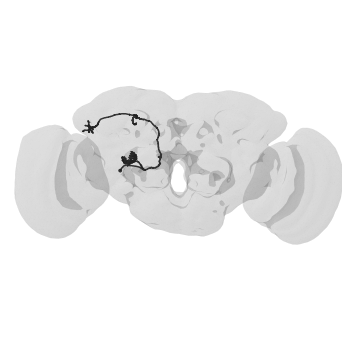

In [41]:
n = pns_syn.idx[id]
fig, ax = navis.plot2d([n, brain], connectors=False, color='k', lw=1.5)
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('example_neuron1.png', transparent=True, dpi=400)

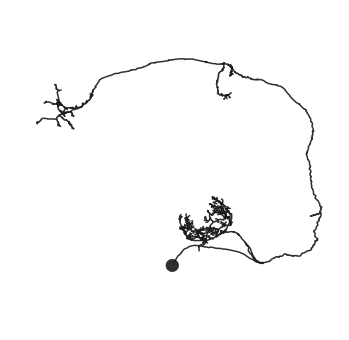

In [72]:
n = pns_syn.idx[id]
fig, ax = navis.plot2d(n, connectors=False, color='k', lw=1.5)
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('example_neuron1_no_brain.png', transparent=True, dpi=400)

In [106]:
fig, ax = navis.plot2d([pns, brain], connectors=False, lw=1, method='3d_complex')
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('all_pns.png', transparent=True, dpi=400)
plt.close()

<Figure size 432x432 with 0 Axes>

In [10]:
fig, ax = navis.plot2d([pns, brain], connectors_only=True, method='3d')
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('all_pns_syn_only.png', transparent=True, dpi=400)
plt.close()

In [176]:
import matplotlib.colors as mcl

for cmp, c in zip(['cellbodyfiber', 'dendrite', 'linker', 'axon'],
                  ['slategrey', 'blue', 'lightgreen', 'red']):
    this = splits[splits.compartment == cmp]
    for n in this:
        n.color = mcl.to_rgb(c)

In [33]:
fig, ax = navis.plot2d([splits, brain], connectors=False, lw=1, method='3d_complex', color=splits.color)
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('all_pns_splits.png', transparent=True, dpi=400)
plt.close()

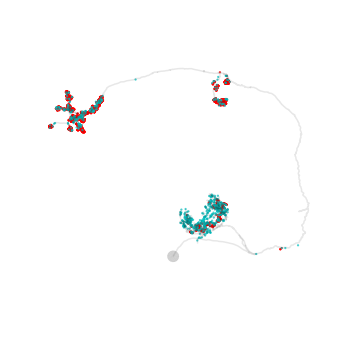

In [62]:
n = pns_syn.idx[id]
fig, ax = navis.plot2d(n,
                       connectors=True, color='k', lw=1.5, alpha=.1, cn_alpha=.7,
                       cn_size=5)
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('example_neuron1_synapses.png', transparent=True, dpi=400)

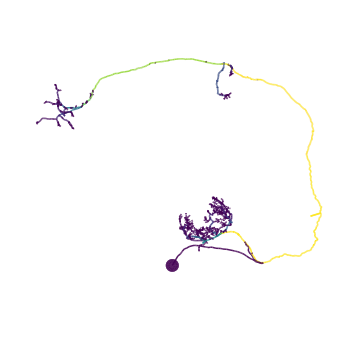

In [19]:
n = pns_syn.idx[id]
navis.arbor_segregation_index(n)
fig, ax = navis.plot2d(n,
                       connectors=False, lw=1.5, 
                       color_by='flow_centrality', palette='viridis')
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('example_neuron1_flow.png', transparent=True, dpi=400)

In [24]:
fig, ax = navis.plot2d([pns_syn, brain],
                       connectors=False, lw=1, norm_global=False,
                       color_by='flow_centrality', shade_by='flow_centrality', palette='viridis')
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('all_pns_flow.png', transparent=True, dpi=400)
plt.close()

/Users/philipps/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



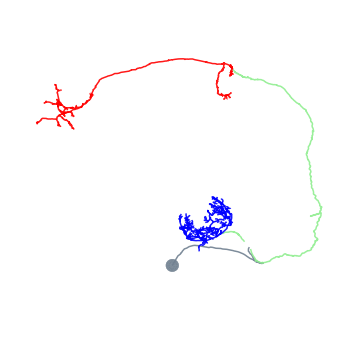

In [31]:
n = splits.idx[id]
fig, ax = navis.plot2d(n,
                       connectors=False, lw=1.5, color=['slategrey', 'blue', 'lightgreen', 'red'],
                       palette='viridis')
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('example_neuron1_split.png', transparent=True, dpi=400)

In [11]:
axons = splits[splits.compartment == 'axon']
dendrite = splits[splits.compartment == 'dendrite']
linker = splits[splits.compartment == 'linker']
pnt = splits[splits.compartment == 'cellbodyfiber']  
axon_dendrites = axons + dendrite

In [35]:
fig, ax = navis.plot2d([axons.connectors[['x', 'y', 'z']].values, brain], method='3d', scatter_kws=dict(c='r', alpha=.05))
_ = navis.plot2d(dendrite.connectors[['x', 'y', 'z']].values, method='3d', scatter_kws=dict(c='b', alpha=.05), ax=ax)
_ = navis.plot2d(pnt.connectors[['x', 'y', 'z']].values, method='3d', scatter_kws=dict(c='darkgrey', alpha=.015), ax=ax)
_ = navis.plot2d(linker.connectors[['x', 'y', 'z']].values, method='3d', scatter_kws=dict(c='g', alpha=.05), ax=ax)
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('all_pns_syn_axo_v_dend.png', transparent=True, dpi=400)
plt.close()

### Plotting done - let's quantify!

In [12]:
# First: a summary of # of pre/postsynapses that ended up on axon vs dendrite
summary = pd.DataFrame([])
summary['id'] = axons.id
summary['name'] = axons.name
for cmp  in ['axon', 'dendrite', 'cellbodyfiber', 'linker']:
    this = splits[splits.compartment == cmp]
    this_pre = dict(zip(this.id, this.n_presynapses))
    this_post = dict(zip(this.id, this.n_postsynapses))
    summary[f'{cmp}_pre'] = summary.id.map(this_pre).fillna(0)
    summary[f'{cmp}_post'] = summary.id.map(this_post).fillna(0)

navis.set_loggers('ERROR')    
summary['SI'] = [navis.segregation_index(axon_dendrites.idx[s]) for s in summary['id'].values]
navis.set_loggers('WARNING')
    
summary.head()

,id,name,axon_pre,axon_post,dendrite_pre,dendrite_post,cellbodyfiber_pre,cellbodyfiber_post,linker_pre,linker_post,SI
0,2863104,Uniglomerular mALT DA1 lPN 57316 2863105 ML,3657,132,504,371,0,1,0,0,0.267004
1,57349,Uniglomerular mALT DA3 adPN 57350 HG,1910,93,1623,148,0,0,0,0,0.012125
2,57353,Uniglomerular mALT DA1 lPN 57354 GA,2719,62,381,255,0,0,0,3,0.312764
3,16,Uniglomerular mALT VA6 adPN 017 DB,14407,510,2552,1615,0,0,9,2,0.249247
4,57361,Uniglomerular mALT VA5 lPN 57362 ML,4089,169,875,247,0,0,9,3,0.110661


In [13]:
# Add some extra info like lineage and PN-type to the dataframe
import re

def get_lineage(x):
    if 'VUMa2' in x:
        return 'VUMa2'
    return re.search('.* (.*PN) ', x).group(1)

summary['ntype'] = 'mPN'
summary['trivial'] = summary.name.map(get_lineage)
summary.loc[summary['id'].isin(pns.has_annotation('WTPN2017_class_uPN_right').id),  'ntype'] = 'uPN'
summary.head()

,id,name,axon_pre,axon_post,dendrite_pre,dendrite_post,cellbodyfiber_pre,cellbodyfiber_post,linker_pre,linker_post,SI,ntype,trivial
0,2863104,Uniglomerular mALT DA1 lPN 57316 2863105 ML,3657,132,504,371,0,1,0,0,0.267004,uPN,lPN
1,57349,Uniglomerular mALT DA3 adPN 57350 HG,1910,93,1623,148,0,0,0,0,0.012125,uPN,adPN
2,57353,Uniglomerular mALT DA1 lPN 57354 GA,2719,62,381,255,0,0,0,3,0.312764,uPN,lPN
3,16,Uniglomerular mALT VA6 adPN 017 DB,14407,510,2552,1615,0,0,9,2,0.249247,uPN,adPN
4,57361,Uniglomerular mALT VA5 lPN 57362 ML,4089,169,875,247,0,0,9,3,0.110661,uPN,lPN


In [104]:
# Quick sanity check
summary.groupby('ntype').SI.describe()

,count,mean,std,min,25%,50%,75%,max
ntype,,,,,,,,
mPN,185.0,0.285908,0.199610,0.001921,0.126270,0.241799,0.444348,0.835853
uPN,163.0,0.286055,0.168866,0.012125,0.188356,0.253464,0.308838,0.827723


### Another round of plotting

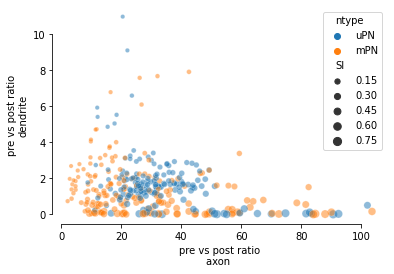

In [108]:
# Plot overview - also sanity check
summary['axon_io'] = summary.axon_pre / summary.axon_post
summary['dend_io'] = summary.dendrite_pre / summary.dendrite_post
ax = sns.scatterplot(data=summary, x='axon_io', y='dend_io', color='firebrick', hue='ntype', alpha=.5, size='SI')
#ax = sns.kdeplot(data=summary, x="axon_io", y="dend_io", hue="ntype")

ax.set_xlabel('pre vs post ratio\naxon ')
ax.set_ylabel('pre vs post ratio\ndendrite')

sns.despine(trim=True)

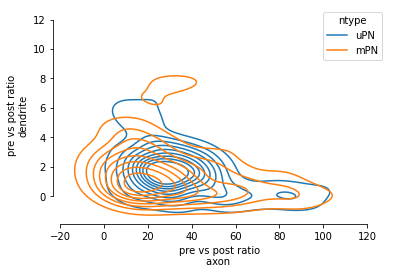

In [107]:
summary['axon_io'] = summary.axon_pre / summary.axon_post
summary['dend_io'] = summary.dendrite_pre / summary.dendrite_post
#ax = sns.scatterplot(data=summary, x='axon_io', y='dend_io', color='firebrick', hue='ntype', alpha=.5)
ax = sns.kdeplot(data=summary, x="axon_io", y="dend_io", hue="ntype")

ax.set_xlabel('pre vs post ratio\naxon ')
ax.set_ylabel('pre vs post ratio\ndendrite')

sns.despine(trim=True)


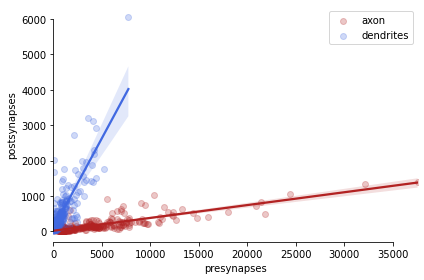

In [106]:
sns.set_color_codes('muted')

ax = None
ax = sns.regplot(data=summary, x='axon_pre', y='axon_post', color='firebrick', ax=ax, label='axon', scatter_kws={'alpha':.25})
ax = sns.regplot(data=summary, x='dendrite_pre', y='dendrite_post', color='royalblue', ax=ax, label='dendrites', scatter_kws={'alpha':.25})

ax.set_xlabel('presynapses')
ax.set_ylabel('postsynapses')

l = ax.legend()
l.set_title('')

#_ = ax.plot([0,8000], [0, 8000], ls='--', alpha=.7, c='k', zorder=0)

sns.despine(trim=True)
plt.tight_layout()
plt.savefig('prepost_axon_dendr.pdf', transparent=True)

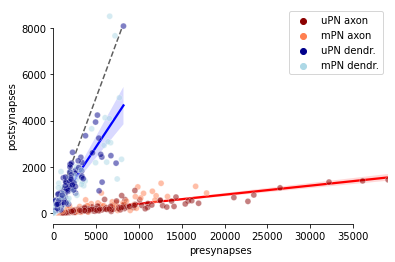

In [204]:
sns.set_color_codes('muted')

summary2 = summary.copy()
summary2['ntype_axon'] = ''
summary2['ntype_dendrites'] = ''
summary2.loc[summary2.ntype == 'uPN', 'ntype_axon'] = 'uPN axon'
summary2.loc[summary2.ntype == 'mPN', 'ntype_axon'] = 'mPN axon'
summary2.loc[summary2.ntype == 'uPN', 'ntype_dendrites'] = 'uPN dendr.'
summary2.loc[summary2.ntype == 'mPN', 'ntype_dendrites'] = 'mPN dendr.'

ax = None
ax = sns.regplot(data=summary2, x='axon_pre', y='axon_post', color='red', ax=ax, scatter=False)
ax = sns.regplot(data=summary2, x='dendrite_pre', y='dendrite_post', color='blue', ax=ax, scatter=False)
ax = sns.scatterplot(data=summary2, x='axon_pre', y='axon_post', hue='ntype_axon', palette=['darkred', 'coral'], ax=ax, alpha=.5, zorder=100)
ax = sns.scatterplot(data=summary2, x='dendrite_pre', y='dendrite_post', hue='ntype_dendrites', palette=['darkblue', 'lightblue'], ax=ax, alpha=.5, zorder=100)

ax.set_xlabel('presynapses')
ax.set_ylabel('postsynapses')

l = ax.get_legend()
l.set_title('')

_ = ax.plot([0,8000], [0, 8000], ls='--', alpha=.7, c='k', zorder=0)

sns.despine(trim=True)

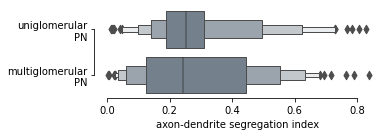

In [105]:
fig, ax = plt.subplots(figsize=(5.5, 2))

ax = sns.boxenplot(data=summary, y='ntype', x='SI', color='slategrey', ax=ax)

ax.set_ylabel('')
ax.set_xlabel('axon-dendrite segregation index')

ax.set_yticklabels(['uniglomerular\nPN', 'multiglomerular\nPN'])

sns.despine(trim=True)
plt.tight_layout()
plt.savefig('uPN_mPN_seg_index.pdf', transparent=True)

### Out of curiosity: compare manually placed and automatically detected synapse numbers

In [29]:
# Let's check Picard and Flywalkies which we have traced extensively (including all synapses) in CATMAID
picard = pns.idx[709943]
picard_syn = picard.copy()

flywalkies = pns.idx[32793]
flywalkies_syn = flywalkies.copy()

synapses.get_neuron_synapses(navis.NeuronList([picard_syn, flywalkies_syn]),
                             db='csv_agglomerated.db',
                             ol_thresh=2, attach=True, collapse_connectors=False)

A connection to a database already exists. Call get_connection() with `force_reconnect=True` to force re-initialization.


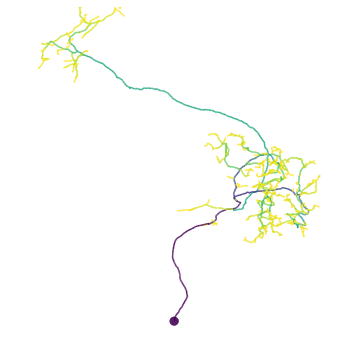

In [75]:
picard.reroot(picard.soma, inplace=True)
navis.strahler_index(picard, method='greedy')

fig, ax = navis.plot2d(picard_man,
                       connectors=False, lw=1.5, color_by='strahler_index',
                       palette='viridis_r')
ax.elev, ax.azim, ax.dist = -90, -90, 5

In [116]:
fig, ax = navis.plot2d(picard,
                       connectors=False, lw=4, color='k')
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('picard_no_prune.png', dpi=300, transparent=True)
plt.close()

xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()

for i in range(1, 4):
    keep = picard.nodes.strahler_index > i
    pruned = navis.subset_neuron(picard, picard.nodes.loc[~keep, 'node_id'].values)
    remainder = navis.subset_neuron(picard, picard.nodes.loc[keep, 'node_id'].values)
    
    fig, ax = navis.plot2d(remainder,
                           connectors=False, lw=4, color='k')
    fig, ax = navis.plot2d(pruned,
                           connectors=False, lw=3., color='lightgrey', ls='-', ax=ax, alpha=.5)
    ax.elev, ax.azim, ax.dist = -90, -90, 5
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    
    plt.savefig(f'picard_prune_{i}.png', dpi=300, transparent=True)
    plt.close()

In [36]:
print(f'Picard presynapses: {picard_man.n_presynapses} manual vs {picard_syn.n_presynapses} Buhmann')
print(f'Picard postsynapses: {picard_man.n_postsynapses} manual vs {picard_syn.n_postsynapses} Buhmann')

print(f'FlyWalkies presynapses: {flywalkies_man.n_presynapses} manual vs {flywalkies_syn.n_presynapses} Buhmann')
print(f'FlyWalkies postsynapses: {flywalkies_man.n_postsynapses} manual vs {flywalkies_syn.n_postsynapses} Buhmann')

Picard presynapses: 107 manual vs 1786 Buhmann
Picard postsynapses: 643 manual vs 755 Buhmann
FlyWalkies presynapses: 800 manual vs 8037 Buhmann
FlyWalkies postsynapses: 2108 manual vs 1691 Buhmann


In [40]:
navis.strahler_index(navis.NeuronList([picard, flywalkies]), method='greedy')
al = pymaid.get_volume('AL_R')

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


In [67]:
to_prune = navis.NeuronList([picard, flywalkies]).copy()

pruning_data = []

# Run one round where we just prune the neuron without re-assigning the synapses
synapses.get_neuron_synapses(to_prune,
                             db='sv_agglomerated.db', ol_thresh=2, attach=True, collapse_connectors=False)

for i in range(0, 5):
    # Prune neuron by strahler order
    if i > 0:
        pruned = navis.prune_by_strahler(to_prune, to_prune=slice(0, i))
    else:
        pruned = to_prune.copy()
        
    # Check which ones are in the AL before re-assignement
    for n in pruned:
        n.connectors['in_al'] = navis.in_volume(n.connectors[['x', 'y', 'z']].values, al)
        n.n_presynapses_al = n.connectors[n.connectors.in_al & (n.connectors.type == 'pre')].shape[0]
        n.n_postsynapses_al = n.connectors[n.connectors.in_al & (n.connectors.type == 'post')].shape[0]
        n.pruned_by = i        
        
    pruning_data.append(pruned.summary(add_props=['n_presynapses', 'n_postsynapses', 'n_presynapses_al', 'n_postsynapses_al', 'pruned_by']))
    pruning_data[-1]['syn_recomputed'] = False        


# Run another round where we re-assign synapses after pruning - this way the segmentation can 
# help us catch some of the bits we have missed. Addresses a slightly different question
for i in range(0, 5):
    # Prune neuron by strahler order
    if i > 0:
        pruned = navis.prune_by_strahler(to_prune, to_prune=slice(0, i))
    else:
        pruned = to_prune.copy()        
        
    # Re-assign synapses based on pruned neuron
    synapses.get_neuron_synapses(pruned,
                                 db='csv_agglomerated.db', ol_thresh=2, attach=True, collapse_connectors=False)

    # Check which ones are in the AL 
    for n in pruned:
        n.connectors['in_al'] = navis.in_volume(n.connectors[['x', 'y', 'z']].values, al)
        n.n_presynapses_al = n.connectors[n.connectors.in_al & (n.connectors.type == 'pre')].shape[0]
        n.n_postsynapses_al = n.connectors[n.connectors.in_al & (n.connectors.type == 'post')].shape[0]
        n.pruned_by = i
        
    pruning_data.append(pruned.summary(add_props=['n_presynapses', 'n_postsynapses', 'n_presynapses_al', 'n_postsynapses_al', 'pruned_by']))
    pruning_data[-1]['syn_recomputed'] = True
    
pruning_data = pd.concat(pruning_data, axis=0)
pruning_data.head()

A connection to a database already exists. Call get_connection() with `force_reconnect=True` to force re-initialization.


A connection to a database already exists. Call get_connection() with `force_reconnect=True` to force re-initialization.


A connection to a database already exists. Call get_connection() with `force_reconnect=True` to force re-initialization.


A connection to a database already exists. Call get_connection() with `force_reconnect=True` to force re-initialization.


Segment IDs:   0%|          | 0/15625 [00:00<?, ?it/s]

A connection to a database already exists. Call get_connection() with `force_reconnect=True` to force re-initialization.


Segment IDs:   0%|          | 0/13390 [00:00<?, ?it/s]

A connection to a database already exists. Call get_connection() with `force_reconnect=True` to force re-initialization.


,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units,compartment,n_presynapses,n_postsynapses,n_presynapses_al,n_postsynapses_al,pruned_by,syn_recomputed
0,CatmaidNeuron,Multiglomerular mlALT vPN VC4+DC4+DM4+11 LTS 0...,709943,10287,2541,423,434,2093654.750,[3348905],1 nanometer,NA,1786,755,732,656,0,False
1,CatmaidNeuron,Multiglomerular mALT l2PN VM1+VP2+VP3+23 LTS 0...,32793,32757,9728,1956,2008,6449531.500,[11614584],1 nanometer,NA,8037,1691,1057,1448,0,False
0,CatmaidNeuron,Multiglomerular mlALT vPN VC4+DC4+DM4+11 LTS 0...,709943,6548,1484,102,105,1543003.875,[3348905],1 nanometer,NA,1099,385,439,353,1,False
1,CatmaidNeuron,Multiglomerular mALT l2PN VM1+VP2+VP3+23 LTS 0...,32793,19077,5402,513,519,4384042.000,[11614584],1 nanometer,NA,4758,644,687,574,1,False
0,CatmaidNeuron,Multiglomerular mlALT vPN VC4+DC4+DM4+11 LTS 0...,709943,5194,1172,65,67,1312657.250,[3348905],1 nanometer,NA,902,270,366,246,2,False


In [68]:
pruning_data['n_presynapses_axon'] = pruning_data.n_presynapses - pruning_data.n_presynapses_al
pruning_data['n_postsynapses_axon'] = pruning_data.n_postsynapses - pruning_data.n_postsynapses_al

total_pre = pruning_data[pruning_data.pruned_by == 0].set_index('id').n_presynapses.to_dict()
total_post = pruning_data[pruning_data.pruned_by == 0].set_index('id').n_postsynapses.to_dict()

al_pre = pruning_data[pruning_data.pruned_by == 0].set_index('id').n_presynapses_al.to_dict()
al_post = pruning_data[pruning_data.pruned_by == 0].set_index('id').n_postsynapses_al.to_dict()

axon_pre = pruning_data[pruning_data.pruned_by == 0].set_index('id').n_presynapses_axon.to_dict()
axon_post = pruning_data[pruning_data.pruned_by == 0].set_index('id').n_postsynapses_axon.to_dict()

total_cable = pruning_data[pruning_data.pruned_by == 0].set_index('id').cable_length.to_dict()

pruning_data['frac_pre'] = pruning_data.n_presynapses / pruning_data.id.map(total_pre)
pruning_data['frac_post'] = pruning_data.n_postsynapses / pruning_data.id.map(total_post)

pruning_data['frac_pre_al'] = pruning_data.n_presynapses_al / pruning_data.id.map(al_pre)
pruning_data['frac_post_al'] = pruning_data.n_postsynapses_al / pruning_data.id.map(al_post)

pruning_data['frac_pre_axon'] = pruning_data.n_presynapses_axon / pruning_data.id.map(axon_pre)
pruning_data['frac_post_axon'] = pruning_data.n_postsynapses_axon / pruning_data.id.map(axon_post)

pruning_data['frac_cable'] = pruning_data.cable_length / pruning_data.id.map(total_cable)

pruning_data.head()

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units,...,syn_recomputed,n_presynapses_axon,n_postsynapses_axon,frac_pre,frac_post,frac_pre_al,frac_post_al,frac_pre_axon,frac_post_axon,frac_cable
0,CatmaidNeuron,Multiglomerular mlALT vPN VC4+DC4+DM4+11 LTS 0...,709943,10287,2541,423,434,2093654.750,[3348905],1 nanometer,...,False,1054,99,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,CatmaidNeuron,Multiglomerular mALT l2PN VM1+VP2+VP3+23 LTS 0...,32793,32757,9728,1956,2008,6449531.500,[11614584],1 nanometer,...,False,6980,243,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0,CatmaidNeuron,Multiglomerular mlALT vPN VC4+DC4+DM4+11 LTS 0...,709943,6548,1484,102,105,1543003.875,[3348905],1 nanometer,...,False,660,32,0.615342,0.509934,0.599727,0.538110,0.626186,0.323232,0.736991
1,CatmaidNeuron,Multiglomerular mALT l2PN VM1+VP2+VP3+23 LTS 0...,32793,19077,5402,513,519,4384042.000,[11614584],1 nanometer,...,False,4071,70,0.592012,0.380840,0.649953,0.396409,0.583238,0.288066,0.679746
0,CatmaidNeuron,Multiglomerular mlALT vPN VC4+DC4+DM4+11 LTS 0...,709943,5194,1172,65,67,1312657.250,[3348905],1 nanometer,...,False,536,24,0.505039,0.357616,0.500000,0.375000,0.508539,0.242424,0.626969


In [114]:
pruning_data[(pruning_data.id == '709943') & pruning_data.syn_recomputed].groupby('pruned_by')[['frac_pre', 'frac_post', 'frac_cable']].describe()

frac_pre                                                        \
             count      mean std       min       25%       50%       75%   
pruned_by                                                                  
0              1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
1              1.0  0.621501 NaN  0.621501  0.621501  0.621501  0.621501   
2              1.0  0.531355 NaN  0.531355  0.531355  0.531355  0.531355   
3              1.0  0.394177 NaN  0.394177  0.394177  0.394177  0.394177   
4              1.0  0.331467 NaN  0.331467  0.331467  0.331467  0.331467   

                    frac_post            ...                     frac_cable  \
                max     count      mean  ...       75%       max      count   
pruned_by                                ...                                  
0          1.000000       1.0  1.000000  ...  1.000000  1.000000        1.0   
1          0.621501       1.0  0.520530  ...  0.520530  0.520530        1.0   
2          0.531355       1.0  0.362914  ...  0.362914  0.362914        1.0   
3          0.394177       1.0  0.241060  ...  0.241060  0.241060        1.0   
4          0.331467       1.0  0.178808  ...  0.178808  0.178808        1.0   

                                                                           
               mean std       min       25%       50%       75%       max  
pruned_by                                                                  
0          1.000000 NaN  1.000000  1.000000  1.000000  1.000000  1.000000  
1          0.736991 NaN  0.736991  0.736991  0.736991  0.736991  0.736991  
2          0.626969 NaN  0.626969  0.626969  0.626969  0.626969  0.626969  
3          0.529741 NaN  0.529741  0.529741  0.529741  0.529741  0.529741  
4          0.470201 NaN  0.470201  0.470201  0.470201  0.470201  0.470201  

[5 rows x 24 columns]

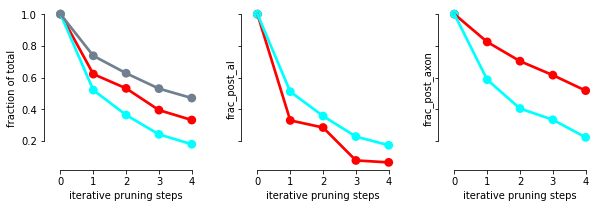

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, sharex=True)

to_plot = pruning_data[(pruning_data.id == '709943') & pruning_data.syn_recomputed]

ax = sns.pointplot(data=to_plot, x='pruned_by', y='frac_pre', label='fraction of presynapses', color='red', ax=axes[0])
ax = sns.pointplot(data=to_plot, x='pruned_by', y='frac_post', label='fraction of presynapses', color='cyan', ax=axes[0])
ax = sns.pointplot(data=to_plot, x='pruned_by', y='frac_cable', label='fraction of cable', color='slategrey', ax=axes[0])

ax = sns.pointplot(data=to_plot, x='pruned_by', y='frac_pre_al', label='fraction of presynapses', color='red', ax=axes[1])
ax = sns.pointplot(data=to_plot, x='pruned_by', y='frac_post_al', label='fraction of presynapses', color='cyan', ax=axes[1])

ax = sns.pointplot(data=to_plot, x='pruned_by', y='frac_pre_axon', label='fraction of presynapses', color='red', ax=axes[2])
ax = sns.pointplot(data=to_plot, x='pruned_by', y='frac_post_axon', label='fraction of presynapses', color='cyan', ax=axes[2])

axes[0].set_ylabel("fraction of total")

for ax in axes:
    ax.set_xlabel("iterative pruning steps")

sns.despine(trim=True)

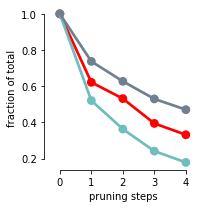

In [98]:
fig, ax = plt.subplots(figsize=(3, 3), sharey=True, sharex=True)

to_plot = pruning_data[(pruning_data.id == '709943') & pruning_data.syn_recomputed]

ax = sns.pointplot(data=to_plot, x='pruned_by', y='frac_pre', label='fraction of presynapses', color='red', ax=ax)
ax = sns.pointplot(data=to_plot, x='pruned_by', y='frac_post', label='fraction of presynapses', color=(110/255, 190/255, 190/255), ax=ax)
ax = sns.pointplot(data=to_plot, x='pruned_by', y='frac_cable', label='fraction of cable', color='slategrey', ax=ax)

ax.set_ylabel("fraction of total")
ax.set_xlabel("pruning steps")

sns.despine(trim=True)
plt.tight_layout()
plt.savefig(f'pruning.pdf', dpi=400, transparent=True)

### Last but not least: some examples for well- and not-so-well segregated (i.e. polarized) PNs

In [234]:
al = pymaid.get_volume('AL_R')
al.color = (230, 230, 230, .1)

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


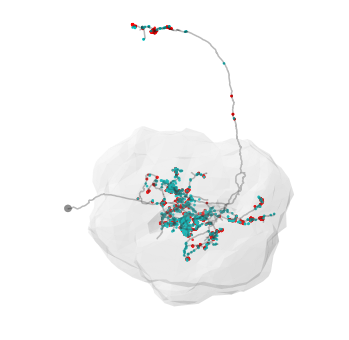

In [235]:
n = pns_syn.idx[57446]
fig, ax = navis.plot2d([n, al],
                       connectors=True, color='k', lw=1.5, alpha=.3, cn_alpha=.9,
                       cn_size=7)
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('example_neuron_not_seg.png', transparent=True, dpi=400)

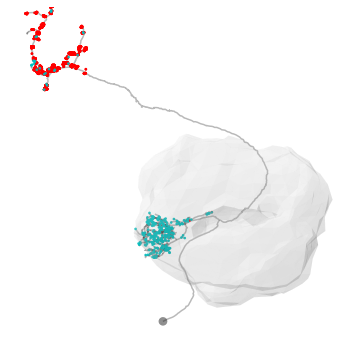

In [236]:
n = pns_syn.idx[1702624]
fig, ax = navis.plot2d([n, al],
                       connectors=True, color='k', lw=1.5, alpha=.3, cn_alpha=.9,
                       cn_size=7)
ax.elev, ax.azim, ax.dist = -90, -90, 5
plt.savefig('example_neuron_well_seg.png', transparent=True, dpi=400)